## 8-5. 프로젝트 : 개선된 U-Net 모델 만들기

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

print('슝=3')

슝=3


In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

#### Albumentation(fast image augmentation library )중 다양한 augmentation 기법을 확률적으로 적용할 수 있게 해주는 Compose()의 활용합니다.

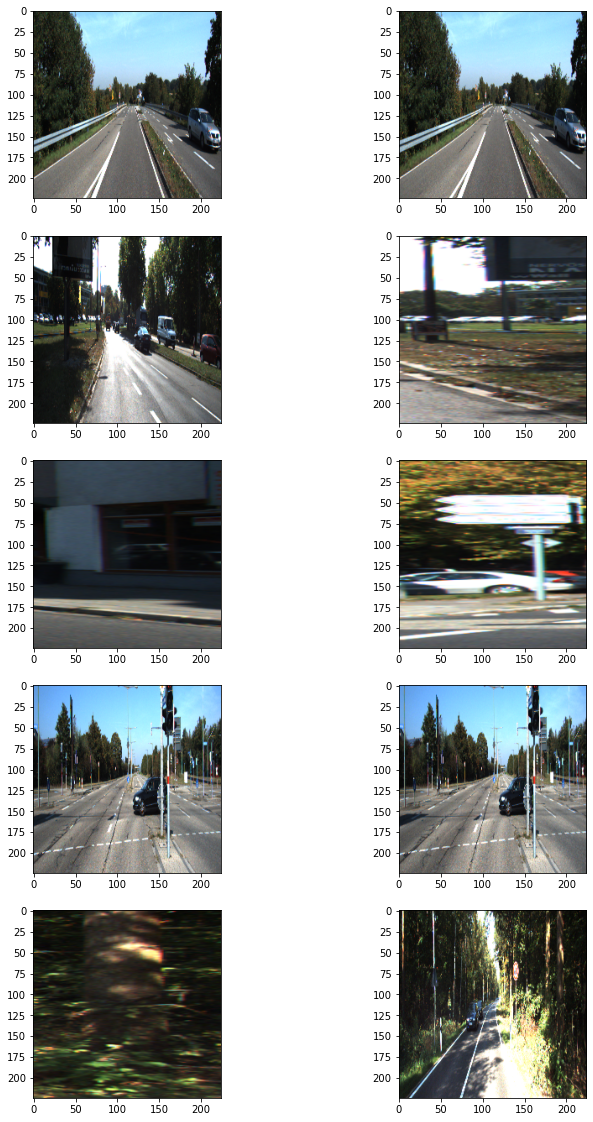

In [3]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))
 
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

#### 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅니다.

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=4,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

####  tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성합니다.

In [6]:
def build_model(input_shape=(224, 224, 3)):
    model = None
    # TODO: input_shape에 따라 U-Net을 만들어주세요
    # 이때 model은 fully convolutional해야 합니다.
    return model

In [7]:
# 예시코드

def build_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)

    #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

In [8]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [9]:
model = build_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_unet.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

/home/aiffel-dj50/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
43/43 [==============================] - 33s 202ms/step - loss: 0.6258 - val_loss: 0.1021
Epoch 2/100
43/43 [==============================] - 8s 184ms/step - loss: 0.2104 - val_loss: 0.1566
Epoch 3/100
43/43 [==============================] - 8s 186ms/step - loss: 0.1101 - val_loss: 0.0961
Epoch 4/100
43/43 [==============================] - 8s 186ms/step - loss: 0.0769 - val_loss: 0.0817
Epoch 5/100
43/43 [==============================] - 8s 186ms/step - loss: 0.0806 - val_loss: 0.0845
Epoch 6/100
43/43 [==============================] - 8s 190ms/step - loss: 0.0790 - val_loss: 0.1095
Epoch 7/100
43/43 [==============================] - 8s 182ms/step - loss: 0.0812 - val_loss: 0.0785
Epoch 8/100
43/43 [==============================] - 8s 193ms/step - loss: 0.0729 - val_loss: 0.0756
Epoch 9/100
43/43 [==============================] - 8s 194ms/step - loss: 0.0732 - val_loss: 0.0802
Epoch 10/100
43/43 [==============================] - 8s 189ms/step - loss: 0.0629 - val_l

#### 시맨틱 세그멘테이션을 위해 모델 중 구조상 비교적 구현이 단순한 U-Net을 구현해 보고, 위에서 만들어본 데이터셋을 학습시킵니다.

In [10]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output

#### Image.blend를 활용해서 입력 이미지와 라벨을 한번에 볼 수 있도록 모델의 출력값을 입력 이미지 위에 오버레이(overray)합니다.

In [11]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [12]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [13]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.808765


0.8087654734024757

#### 위에 구현했던 get_output을 좀더 확장해서 output, prediction, target을 함께 리턴하도록 구현하고, 시각화를 진행해 봅니다.

In [14]:
def build_NestedUNet_model(input_shape=(224, 224, 3)):
    
    n1 = 64
    filters = [n1, n1*2, n1*4, n1*8, n1*16]
    
    inputs = Input(input_shape)
    
    # Left Backbone CONV X0,0
    conv0_0_1 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_0_1')(inputs)
    bn0_0_1 = BatchNormalization()(conv0_0_1)
    act0_0_1 = Activation('relu')(bn0_0_1)
    conv0_0_2 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_0_2')(act0_0_1)
    bn0_0_2 = BatchNormalization()(conv0_0_2)
    conv0_0 = Activation('relu')(bn0_0_2)
    
    # Left Backbone CONV X1,0
    conv0_0_D = MaxPooling2D(strides=2)(conv0_0) # 내려가는 부분 Down으로 표기
    conv1_0_1 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_0_1')(conv0_0_D)
    bn1_0_1 = BatchNormalization()(conv1_0_1)
    act1_0_1 = Activation('relu')(bn1_0_1)
    conv1_0_2 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_0_2')(act1_0_1)
    bn1_0_2 = BatchNormalization()(conv1_0_2)
    conv1_0 = Activation('relu')(bn1_0_2)
    
    # Left Backbone CONV X2,0
    conv1_0_D = MaxPooling2D(strides=2)(conv1_0)  # 내려가는 부분 Down으로 표기
    conv2_0_1 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_0_1')(conv1_0_D)
    bn2_0_1 = BatchNormalization()(conv2_0_1)
    act2_0_1 = Activation('relu')(bn2_0_1)
    conv2_0_2 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_0_2')(act2_0_1)
    bn2_0_2 = BatchNormalization()(conv2_0_2)
    conv2_0 = Activation('relu')(bn2_0_2)
    
    # Left Backbone CONV X3,0
    conv2_0_D = MaxPooling2D(strides=2)(conv2_0)  # 내려가는 부분 Down으로 표기
    conv3_0_1 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_0_1')(conv2_0_D)
    bn3_0_1 = BatchNormalization()(conv3_0_1)
    act3_0_1 = Activation('relu')(bn3_0_1)
    conv3_0_2 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_0_2')(act3_0_1)
    bn3_0_2 = BatchNormalization()(conv3_0_2)
    conv3_0 = Activation('relu')(bn3_0_2)
    
    # Left Backbone CONV X4,0
    conv3_0_D = MaxPooling2D(strides=2)(conv3_0)  # 내려가는 부분 Down으로 표기
    conv4_0_1 = Conv2D(filters[4], 3, padding='same', kernel_initializer='he_normal', name='conv4_0_1')(conv3_0_D)
    bn4_0_1 = BatchNormalization()(conv4_0_1)
    act4_0_1 = Activation('relu')(bn4_0_1)
    conv4_0_2 = Conv2D(filters[4], 3, padding='same', kernel_initializer='he_normal', name='conv4_0_2')(act4_0_1)
    bn4_0_2 = BatchNormalization()(conv4_0_2)
    conv4_0 = Activation('relu')(bn4_0_2)  

    # The First Middle Connection CONV X0,1
    conv1_0_U = UpSampling2D()(conv1_0)   # 올라가는 부분 UP으로 표기
    conv0_1_R = Concatenate()([conv0_0, conv1_0_U])  # 오른쪽으로 가는 부분 Right으로 표기   
    conv0_1_1 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_1_1')(conv0_1_R)
    bn0_1_1 = BatchNormalization()(conv0_1_1)
    act0_1_1 = Activation('relu')(bn0_1_1)
    conv0_1_2 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_1_2')(act0_1_1)
    bn0_1_2 = BatchNormalization()(conv0_1_2)
    conv0_1 = Activation('relu')(bn0_1_2)
    
    # The First Middle Connection CONV X1,1
    conv2_0_U = UpSampling2D()(conv2_0)   # 올라가는 부분 UP으로 표기
    conv1_1_R = Concatenate()([conv1_0, conv2_0_U])  # 오른쪽으로 가는 부분 Right으로 표기
    conv1_1_1 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_1_1')(conv1_1_R)
    bn1_1_1 = BatchNormalization()(conv1_1_1)
    act1_1_1 = Activation('relu')(bn1_1_1)
    conv1_1_2 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_1_2')(act1_1_1)
    bn1_1_2 = BatchNormalization()(conv1_1_2)
    conv1_1 = Activation('relu')(bn1_1_2)
    
    # The First Middle Connection CONV X2,1
    conv3_0_U = UpSampling2D()(conv3_0)   # 올라가는 부분 UP으로 표기
    conv2_1_R = Concatenate()([conv2_0, conv3_0_U])   # 오른쪽으로 가는 부분 Right으로 표기
    conv2_1_1 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_1_1')(conv2_1_R)
    bn2_1_1 = BatchNormalization()(conv2_1_1)
    act2_1_1 = Activation('relu')(bn2_1_1)
    conv2_1_2 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_1_2')(act2_1_1)
    bn2_1_2 = BatchNormalization()(conv2_1_2)
    conv2_1 = Activation('relu')(bn2_1_2)
    
    # Right Backbone CONV X3,1
    conv4_0_U = UpSampling2D()(conv4_0)   # 올라가는 부분 UP으로 표기
    conv3_1_R = Concatenate()([conv3_0, conv4_0_U])   # 오른쪽으로 가는 부분 Right으로 표기 
    conv3_1_1 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_1_1')(conv3_1_R)
    bn3_1_1 = BatchNormalization()(conv3_1_1)
    act3_1_1 = Activation('relu')(bn3_1_1)
    conv3_1_2 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_1_2')(act3_1_1)
    bn3_1_2 = BatchNormalization()(conv3_1_2)
    conv3_1 = Activation('relu')(bn3_1_2)
    
    # The Second Middle Connection CONV X0,2    
    conv1_1_U = UpSampling2D()(conv1_1)   # 올라가는 부분 UP으로 표기
    conv0_2_R = Concatenate()([conv0_0, conv0_1, conv1_1_U])   # 오른쪽으로 가는 부분 Right으로 표기
    conv0_2_1 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_2_1')(conv0_2_R)
    bn0_2_1 = BatchNormalization()(conv0_2_1)
    act0_2_1 = Activation('relu')(bn0_2_1)
    conv0_2_2 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_2_2')(act0_2_1)
    bn0_2_2 = BatchNormalization()(conv0_2_2)
    conv0_2 = Activation('relu')(bn0_2_2)
    
    # The Second Middle Connection CONV X1,2
    conv2_1_U = UpSampling2D()(conv2_1)   # 올라가는 부분 UP으로 표기
    conv1_2_R = Concatenate()([conv1_0, conv1_1, conv2_1_U])   # 오른쪽으로 가는 부분 Right으로 표기
    conv1_2_1 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_2_1')(conv1_2_R)
    bn1_2_1 = BatchNormalization()(conv1_2_1)
    act1_2_1 = Activation('relu')(bn1_2_1)
    conv1_2_2 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_2_2')(act1_2_1)
    bn1_2_2 = BatchNormalization()(conv1_2_2)
    conv1_2 = Activation('relu')(bn1_2_2)
    
    # Right Backbone CONV X2,2
    conv3_1_U = UpSampling2D()(conv3_1)   # 올라가는 부분 UP으로 표기
    conv2_2_R = Concatenate()([conv2_0, conv2_1, conv3_1_U])   # 오른쪽으로 가는 부분 Right으로 표기
    conv2_2_1 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_2_1')(conv2_2_R)
    bn2_2_1 = BatchNormalization()(conv2_2_1)
    act2_2_1 = Activation('relu')(bn2_2_1)
    conv2_2_2 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_2_2')(act2_2_1)
    bn2_2_2 = BatchNormalization()(conv2_2_2)
    conv2_2 = Activation('relu')(bn2_2_2)
    
    # The Third Middle Connection CONV X0,3
    conv1_2_U = UpSampling2D()(conv1_2)   # 올라가는 부분 UP으로 표기
    conv0_3_R = Concatenate()([conv0_0, conv0_1, conv0_2, conv1_2_U])  # 오른쪽으로 가는 부분 Right으로 표기
    conv0_3_1 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_3_1')(conv0_3_R)
    bn0_3_1 = BatchNormalization()(conv0_3_1)
    act0_3_1 = Activation('relu')(bn0_3_1)
    conv0_3_2 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_3_2')(act0_3_1)
    bn0_3_2 = BatchNormalization()(conv0_3_2)
    conv0_3 = Activation('relu')(bn0_3_2)
    
    # Right Backbone CONV X1,3
    conv2_2_U = UpSampling2D()(conv2_2)   # 올라가는 부분 UP으로 표기
    conv1_3_R = Concatenate()([conv1_0, conv1_1, conv1_2, conv2_2_U])  # 오른쪽으로 가는 부분 Right으로 표기
    conv1_3_1 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_3_1')(conv1_3_R)
    bn1_3_1 = BatchNormalization()(conv1_3_1)
    act1_3_1 = Activation('relu')(bn1_3_1)
    conv1_3_2 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_3_2')(act1_3_1)
    bn1_3_2 = BatchNormalization()(conv1_3_2)
    conv1_3 = Activation('relu')(bn1_3_2)
    
    # Right Backbone CONV X0,4
    conv1_3_U = UpSampling2D()(conv1_3)  # 올라가는 부분 UP으로 표기                                      
    conv0_4_R = Concatenate()([conv0_0, conv0_1, conv0_2, conv0_3, conv1_3_U])  # 오른쪽으로 가는 부분 Right으로 표기
    conv0_4_1 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_4_1')(conv0_4_R)
    bn0_4_1 = BatchNormalization()(conv0_4_1)
    act0_4_1 = Activation('relu')(bn0_4_1)
    conv0_4_2 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_4_2')(act0_4_1)
    bn0_4_2 = BatchNormalization()(conv0_4_2)
    conv0_4 = Activation('relu')(bn0_4_2)
    
    output = Conv2D(1, 1, activation='sigmoid', name='final')(conv0_4)
    
    model = Model(inputs = inputs, outputs = output)
    
    return model

In [15]:
model = build_NestedUNet_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv0_0_1 (Conv2D)              (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 64) 256         conv0_0_1[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 64) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [16]:
model = build_NestedUNet_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_NestedUNet_unet_100.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.


Epoch 1/100
43/43 [==============================] - 41s 432ms/step - loss: 0.3616 - val_loss: 0.4018
Epoch 2/100
43/43 [==============================] - 18s 430ms/step - loss: 0.1818 - val_loss: 0.2745
Epoch 3/100
43/43 [==============================] - 18s 426ms/step - loss: 0.1737 - val_loss: 0.3573
Epoch 4/100
43/43 [==============================] - 18s 427ms/step - loss: 0.1457 - val_loss: 0.2170
Epoch 5/100
43/43 [==============================] - 18s 428ms/step - loss: 0.1299 - val_loss: 0.1973
Epoch 6/100
43/43 [==============================] - 18s 428ms/step - loss: 0.1319 - val_loss: 0.1515
Epoch 7/100
43/43 [==============================] - 18s 421ms/step - loss: 0.1175 - val_loss: 0.1532
Epoch 8/100
43/43 [==============================] - 18s 420ms/step - loss: 0.1167 - val_loss: 0.1390
Epoch 9/100
43/43 [==============================] - 18s 420ms/step - loss: 0.1151 - val_loss: 0.1082
Epoch 10/100
43/43 [==============================] - 18s 422ms/step - loss: 0.106

#### U-Net의 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델인 U-Net++모델을 구현하고 학습시킵니다. 

In [17]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output

In [18]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [19]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [20]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.873553


0.8735528596187175

#### 성능을 정량적으로 측정하기 위한 방법으로 IoU(Intersection over Union)를 계산하는 모델을 구현하고 시각화도 진행해 봅니다

## 총평

### U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석해보니 U-Net++ 모델이 IoU(Intersection over Union)값이 0.87로 U-Net모델의 0.80보다 조금 더 높은 것을 확인할수 있었습니다.